# 6. Diagnóstico de supuestos

## 6.1 Importación de librerías de Python

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.robust.norms import HuberT
from scipy.stats import shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 6.2 Cargue de modelos y matrices de Numpy

In [3]:
path = '../Data/'

X = np.load(path + 'X_def.dat', allow_pickle= True)
B = np.load(path + 'B_def.dat', allow_pickle= True)
Y = np.load(path + 'Y_def.dat', allow_pickle= True)

In [4]:
result =  sm.load(path + 'ols_def_results.pickle')

In [5]:
with open("../Data/regressor_columns_def.pickle", "rb") as fp:   #Pickling
...   regressor_columns_def = pickle.load(fp)

In [7]:
df = pd.read_csv(path+'hour-processed2.csv', delimiter=',')
df_original = pd.read_csv(path+'hour.csv', delimiter=',')

## 6.3 Validación supuesto de linealidad

Validamos el supuesto de linealidad de forma gráfica con el método de 'Residual vs Fitted' (**Figura 6.1**). Aquí buscamos que no se observe ninguna correlación entre los residuos y los valores predichos por el modelo. En nuestro modelo esta asunción parece cumplirse con éxito, dado que la dispersión de los residuos es aleatoria y el coeficiente de correlación calculado es prácticamente 0. 

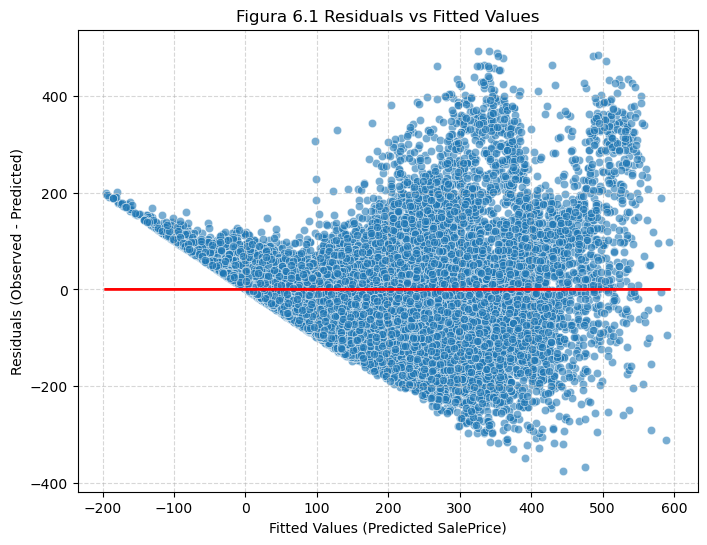

Correlation between fitted values and residuals: 0.0000
Linearity assumption seems reasonable (residuals uncorrelated with fitted values).


In [8]:
# Se obtienen los valores predichos y los residuos
fitted_vals = result.fittedvalues
residuals = result.resid

# 2. Grafica residuo vs predichos

plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.1 Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predicted SalePrice)')
plt.ylabel('Residuals (Observed - Predicted)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Validación estadística
corr = np.corrcoef(fitted_vals, residuals)[0,1]
print(f"Correlation between fitted values and residuals: {corr:.4f}")
if abs(corr) > 0.1:
    print("Possible non-linearity detected (residuals correlated with fitted values).")
else:
    print("Linearity assumption seems reasonable (residuals uncorrelated with fitted values).")

## 6.4 Validación de Homocedasticidad

Validamos homocedasticidad, que es la asunción que la varianza de los errores permanece constante para todas las observaciones, para esto nos apoyamos nuevamente del gráfico de Residuos vs Valores ajustados (**Figura 6.2**) y, adicionalmente, usamos el test de Breusch-Pagan y el de White, obteniendo los sigguientes resultados:

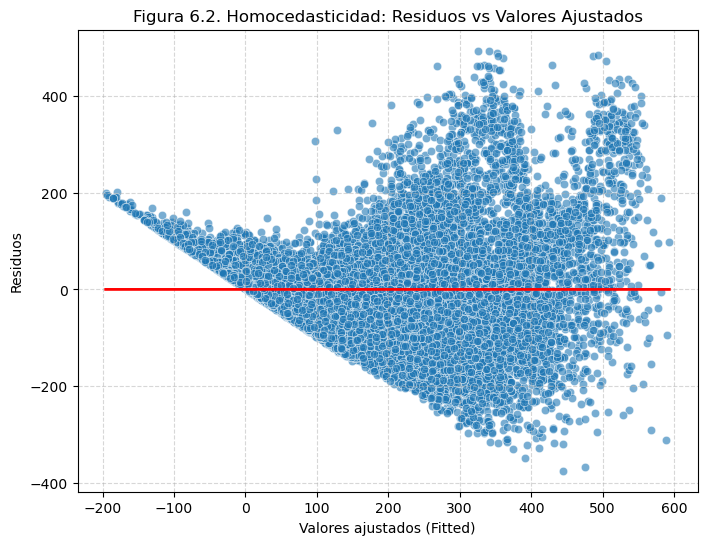


🔹 Resultados Test de Breusch–Pagan:
Lagrange multiplier statistic: 3537.24989
LM-Test p-value: 0.00000
f-value: 277.30296
f p-value: 0.00000
Evidencia de heterocedasticidad (p < 0.05)

🔹 Resultados Test de White:
LM Statistic: 5161.84266
LM p-value: 0.00000
F-Statistic: 52.40007
F p-value: 0.00000
Evidencia de heterocedasticidad según White (p < 0.05)


In [9]:
# Visualización: Residuos vs Valores ajustados
plt.figure(figsize=(8,6))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
sns.lineplot(x=fitted_vals, y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.2. Homocedasticidad: Residuos vs Valores Ajustados')
plt.xlabel('Valores ajustados (Fitted)')
plt.ylabel('Residuos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Test de Breusch–Pagan
bp_test = het_breuschpagan(residuals, result.model.exog)

bp_labels = ['Lagrange multiplier statistic', 'LM-Test p-value', 
             'f-value', 'f p-value']
print("\n🔹 Resultados Test de Breusch–Pagan:")
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.5f}")

if bp_test[1] < 0.05:
    print("Evidencia de heterocedasticidad (p < 0.05)")
else:
    print("No se detecta heterocedasticidad significativa")
    
# Test de White
white_test = het_white(residuals, result.model.exog)

white_labels = ['LM Statistic', 'LM p-value', 'F-Statistic', 'F p-value']
print("\n🔹 Resultados Test de White:")
for name, val in zip(white_labels, white_test):
    print(f"{name}: {val:.5f}")

if white_test[1] < 0.05:
    print("Evidencia de heterocedasticidad según White (p < 0.05)")
else:
    print("No se detecta heterocedasticidad según White")

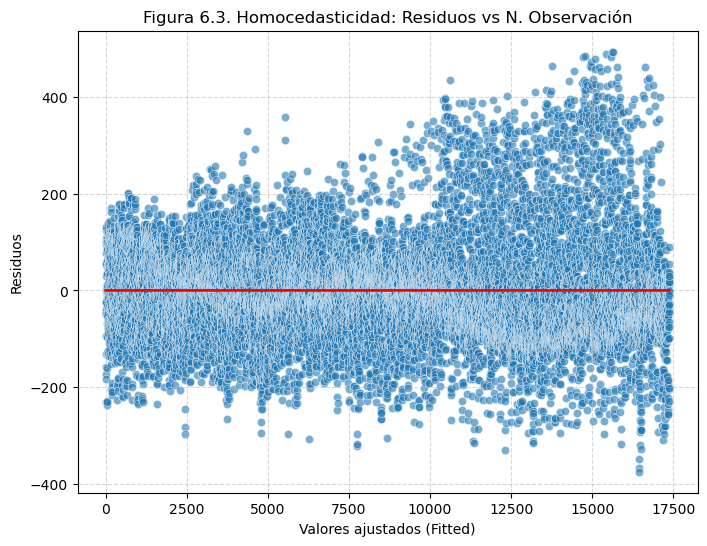

In [10]:
# Visualización: Residuos vs Valores ajustados
plt.figure(figsize=(8,6))
sns.scatterplot(x=range(len(residuals)), y=residuals, alpha=0.6)
sns.lineplot(x=range(len(residuals)), y=[0]*len(fitted_vals), color='red', lw=2)
plt.title('Figura 6.3. Homocedasticidad: Residuos vs N. Observación')
plt.xlabel('Valores ajustados (Fitted)')
plt.ylabel('Residuos')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Analizando los resultados, vemos que no se cumple el criterio de homocedasticidad. Observamos que la varianza de las observaciones no es homogenea a lo largo de las observaciones obtenidas. El uso de metodos más robustos en el siguiente capítulo nos dará una solución a este problema.

## 6.5 Validación de Supuesto de Normalidad (QQ-plot)

Para evualuar normalidad, hacemos un QQ-plot, donde esperamos que la frecuencia de los residuos se alinea a la esperada cuando se cumple la normalidad.

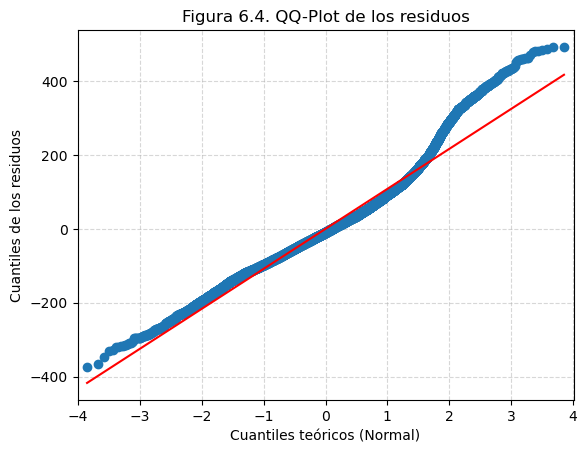

In [11]:
# QQ Plot para evaluar normalidad
sm.qqplot(residuals, line='s', color='blue')
plt.title("Figura 6.4. QQ-Plot de los residuos")
plt.xlabel("Cuantiles teóricos (Normal)")
plt.ylabel("Cuantiles de los residuos")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Observando la **Figura 6.4**, vemos que la normalidad se cumple en una gran parte de los cuantiles, con excepción de los extremos, donde vemos que la frecuencia obtenida es distinta de lo esperado. Esto podría deberse a datos atípico que no fueron eliminados correctamente o a la presencia de observacioens que el modelo falló en interpretar correctamente. Esto puede ser validado con una prueba de Shapiro-Wilk:

In [14]:
# Prueba de Shapiro-Wilk
stat, p_value = shapiro(residuals)

print("Estadístico Shapiro-Wilk:", stat)
print("p-valor:", p_value)

# Interpretación básica
alpha = 0.05
if p_value > alpha:
    print("No se rechaza H0: Los residuos parecen seguir una distribución normal.")
else:
    print("Se rechaza H0: Los residuos NO siguen una distribución normal.")

Estadístico Shapiro-Wilk: 0.9627948849732951
p-valor: 3.873809219202014e-54
Se rechaza H0: Los residuos NO siguen una distribución normal.


## 6.6 Validación de supuesto de autocorrelación

La autocorrelación ocurre cuando los residuos de un modelo de regresión no son independientes entre sí, es decir, cuando el error en una observación está relacionado con el error en otra.

Para validar este supuesto, usamos el metodo de Durbin-Watson, el cual nos entrega un estadístico que nos permite validar la presencia de autocorrelación positiva o negativa.

En nuestro modelo obtuvimos un valor de Durbin-Watson de 0.73, lo que nos indica presencia de autocorrelación positiva, esperable en una serie temporal donde los datos no son completamente independientes entre sí.


Estadístico de Durbin–Watson: 0.7276
Posible autocorrelación positiva de los residuos.


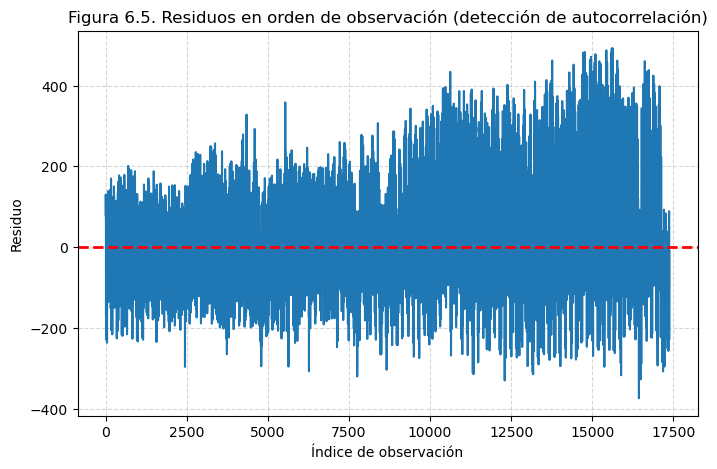

In [15]:
# =============================
# 4. Calcular estadístico de Durbin–Watson
# =============================
dw_stat = durbin_watson(residuals)
print(f"\nEstadístico de Durbin–Watson: {dw_stat:.4f}")

# =============================
# 5. Interpretación
# =============================
if dw_stat < 1.5:
    print("Posible autocorrelación positiva de los residuos.")
elif dw_stat > 2.5:
    print("Posible autocorrelación negativa de los residuos.")
else:
    print("No hay evidencia fuerte de autocorrelación (residuos independientes).")


# Visualización: residuos vs índice (orden de observación)
plt.figure(figsize=(8,5))
sns.lineplot(x=range(len(residuals)), y=residuals)
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.title("Figura 6.5. Residuos en orden de observación (detección de autocorrelación)")
plt.xlabel("Índice de observación")
plt.ylabel("Residuo")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## 6.7 Validación de multicolinealidad

La multicolinealidad ocurre cuando dos o más variables explicativas (predictoras) en un modelo de regresión están altamente correlacionadas entre sí.  
En otras palabras, una variable puede explicarse linealmente a partir de otra (o de un conjunto de otras variables).

Esto genera redundancia en la información: el modelo no puede distinguir claramente el efecto individual de cada predictor sobre la variable dependiente.

En nuestro caso, ya hemos eliminado la multicolinealidad mediante la reducción de variables que eran correalacionadas a otras.

In [18]:
vif_data = pd.DataFrame()
vif_data["Variable"] = regressor_columns_def
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(1, X.shape[1])]

print("\nFactores de inflación de la varianza (VIF):")
print(vif_data)

# =============================
# 3. Interpretación
# =============================
print("\nInterpretación:")
for var, vif in zip(vif_data["Variable"], vif_data["VIF"]):
    if vif < 5:
        print(f"{var}: Sin multicolinealidad significativa (VIF={vif:.2f})")
    elif vif < 10:
        print(f"{var}: Multicolinealidad moderada (VIF={vif:.2f})")
    else:
        print(f"{var}: Alta multicolinealidad (VIF={vif:.2f}) — considerar eliminar o combinar variables.")


Factores de inflación de la varianza (VIF):
        Variable       VIF
0           temp  3.268023
1            hum  1.830780
2      windspeed  1.162374
3             yr  1.018726
4         hr_sin  1.345978
5         hr_cos  1.270048
6    weekday_sin  1.021285
7        day_cos  1.000880
8       mnth_sin  4.878187
9        holiday  1.019514
10     rush_hour  1.050736
11      season_2  2.509319
12      season_3  6.233559
13      season_4  4.033884
14  weathersit_2  1.184791
15  weathersit_3  1.301980

Interpretación:
temp: Sin multicolinealidad significativa (VIF=3.27)
hum: Sin multicolinealidad significativa (VIF=1.83)
windspeed: Sin multicolinealidad significativa (VIF=1.16)
yr: Sin multicolinealidad significativa (VIF=1.02)
hr_sin: Sin multicolinealidad significativa (VIF=1.35)
hr_cos: Sin multicolinealidad significativa (VIF=1.27)
weekday_sin: Sin multicolinealidad significativa (VIF=1.02)
day_cos: Sin multicolinealidad significativa (VIF=1.00)
mnth_sin: Sin multicolinealidad signifi